In [1]:
import yfinance as yf

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [27]:
%matplotlib inline
plt.style.use("ggplot")

In [2]:
symbols = ["MSFT", "NIO"]

In [3]:
tickers = yf.Tickers(symbols)

In [17]:
option_prices = []
for idx, ticker in enumerate(tickers.tickers):
    option_expiry = ticker.options
    underlying_price = ticker.history().tail(1).iloc[0]["Close"]
    for expiry in option_expiry:
        options = ticker.option_chain(expiry)
        calls = options.calls
        calls.loc[:, "optionType"] = "CALL"
        calls.loc[:, "expiry"] = expiry
        calls.loc[:, "underlyingSymbol"] = symbols[idx]
        calls.loc[:, "underlyingPrice"] = underlying_price

        puts = options.puts
        puts.loc[:, "optionType"] = "PUT"
        puts.loc[:, "expiry"] = expiry
        puts.loc[:, "underlyingSymbol"] = symbols[idx]
        puts.loc[:, "underlyingPrice"] = underlying_price

        option_prices.append(calls)
        option_prices.append(puts)
        
option_prices = pd.concat(option_prices)        

In [20]:
option_prices.loc[:, "logMoneyness"] = np.log(option_prices["strike"].values / option_prices["underlyingPrice"].values)

In [23]:
otm_prices_idx = ((option_prices["logMoneyness"] > 0) & (option_prices["optionType"] == "CALL")) | (
    (option_prices["logMoneyness"] <= 0) & (option_prices["optionType"] == "PUT"))

In [24]:
otm_prices = option_prices.loc[otm_prices_idx]

In [35]:
otm_prices[:10]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiry,underlyingSymbol,underlyingPrice,logMoneyness
34,MSFT200214C00190000,2020-02-10 20:59:58,190.0,1.90,1.90,2.00,1.18,163.888870,48015.0,11159,0.328620,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.006866
35,MSFT200214C00192500,2020-02-10 20:59:51,192.5,1.20,1.20,1.23,0.76,172.727280,11374.0,2835,0.341315,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.019938
36,MSFT200214C00195000,2020-02-10 20:59:54,195.0,0.76,0.74,0.79,0.45,145.161290,9441.0,2540,0.364752,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.032841
37,MSFT200214C00197500,2020-02-10 20:59:54,197.5,0.50,0.44,0.51,0.27,117.391290,2798.0,815,0.386725,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.045580
38,MSFT200214C00200000,2020-02-10 20:59:54,200.0,0.34,0.32,0.35,0.16,88.888885,6718.0,2872,0.414068,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.058159
39,MSFT200214C00202500,2020-02-10 20:59:58,202.5,0.25,0.24,0.25,0.06,31.578949,1039.0,679,0.441900,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.070581
40,MSFT200214C00205000,2020-02-10 20:58:38,205.0,0.18,0.16,0.19,0.06,50.000010,3188.0,3076,0.472662,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.082852
41,MSFT200214C00210000,2020-02-10 20:58:38,210.0,0.10,0.10,0.11,0.02,25.000006,581.0,2447,0.523442,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.106949
42,MSFT200214C00215000,2020-02-10 20:57:46,215.0,0.06,0.04,0.06,-0.01,-14.285716,1966.0,5756,0.554692,False,REGULAR,USD,CALL,2020-02-13,MSFT,188.7,0.130480
0,MSFT200214P00125000,2020-01-09 20:40:46,125.0,0.07,0.00,0.03,0.00,0.000000,NaN,3,1.390628,False,REGULAR,USD,PUT,2020-02-13,MSFT,188.7,-0.411845


In [47]:
underlying_price

3.87

In [51]:
200 / np.exp(0.05)

190.24588490014278

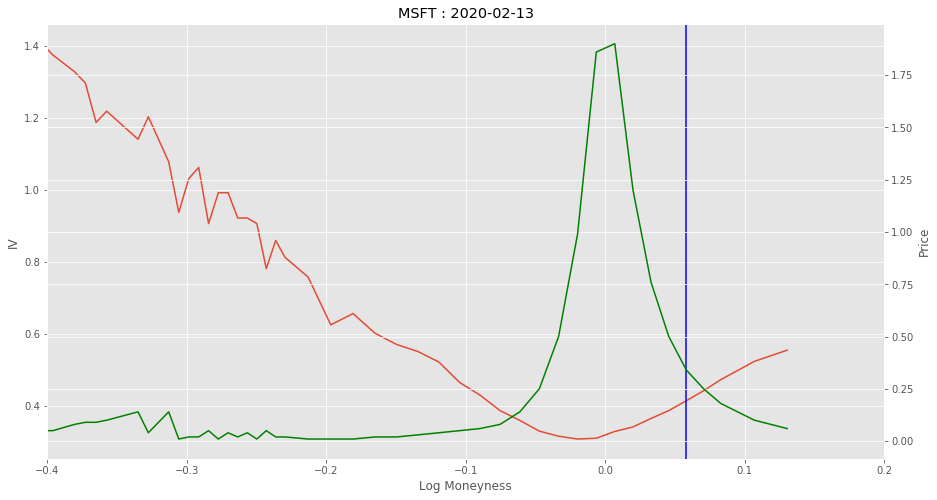

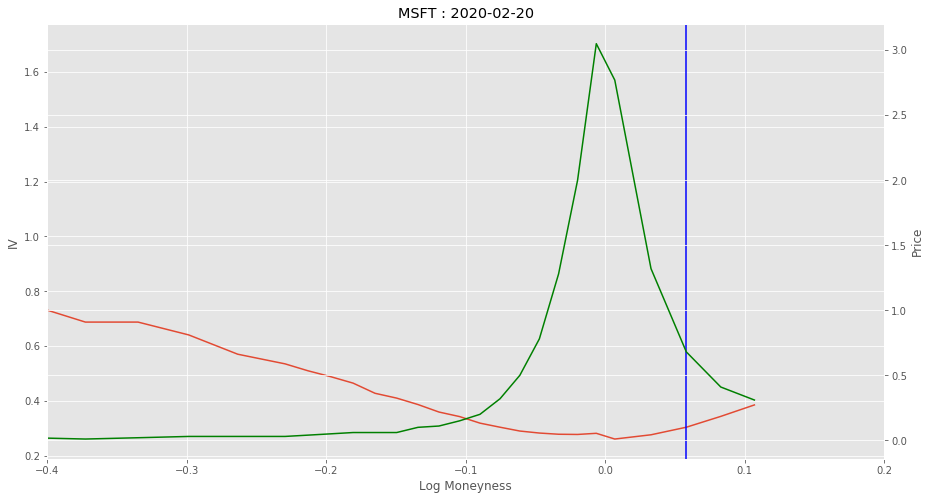

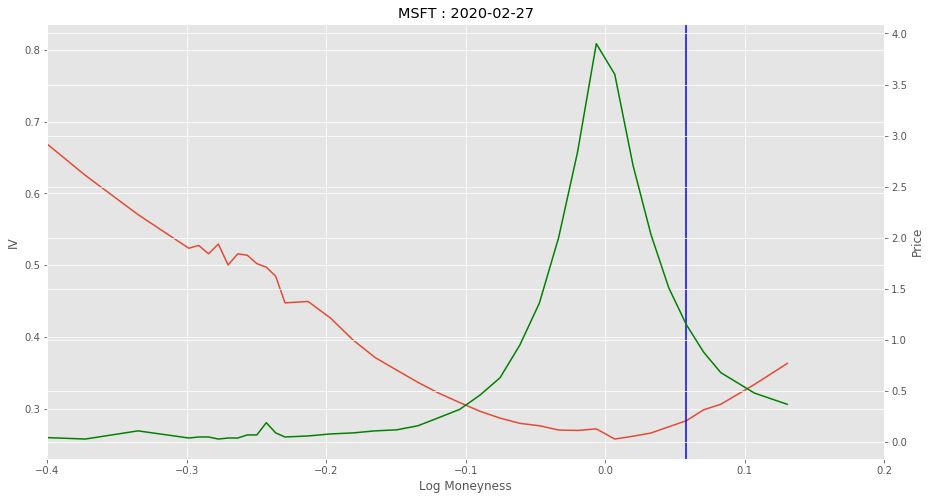

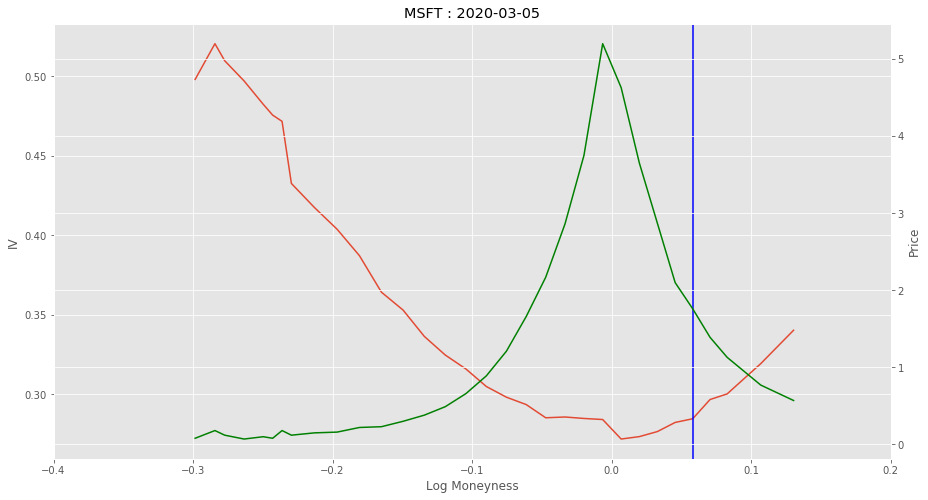

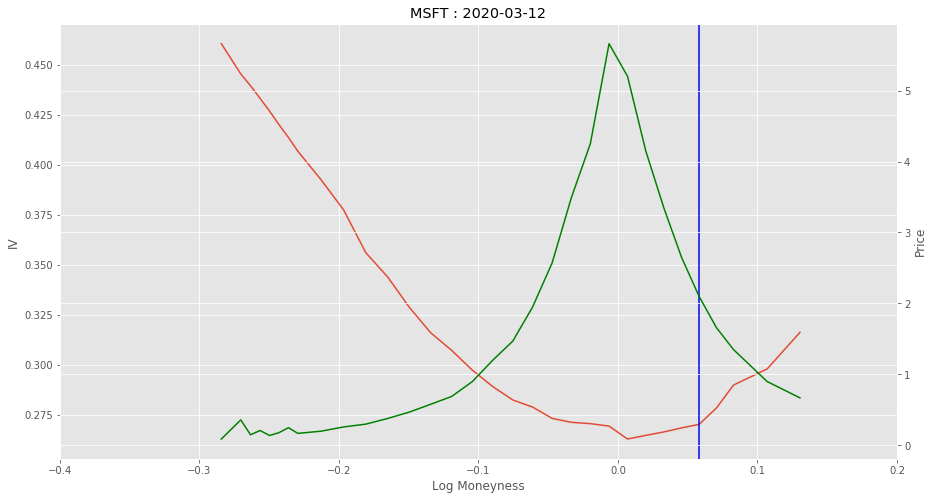

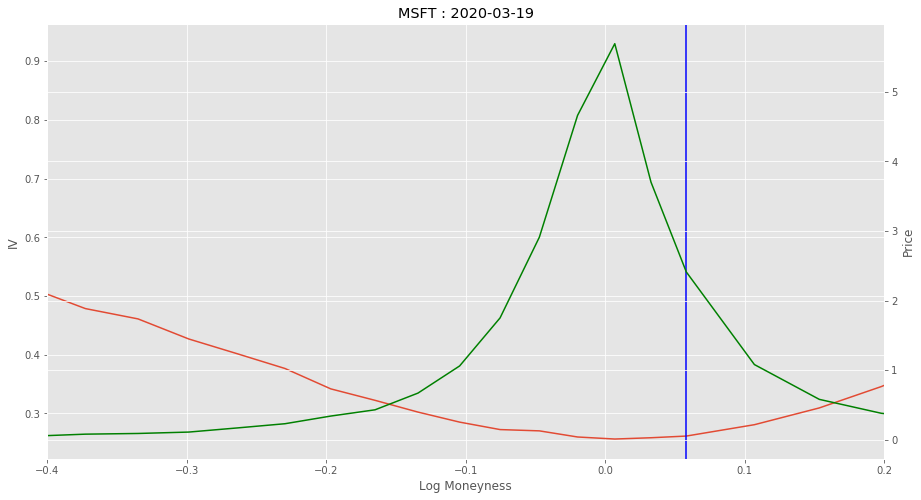

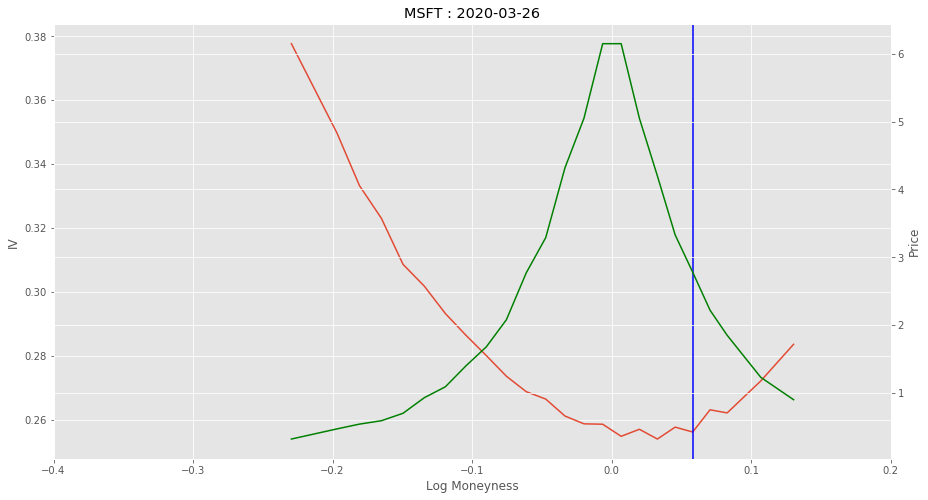

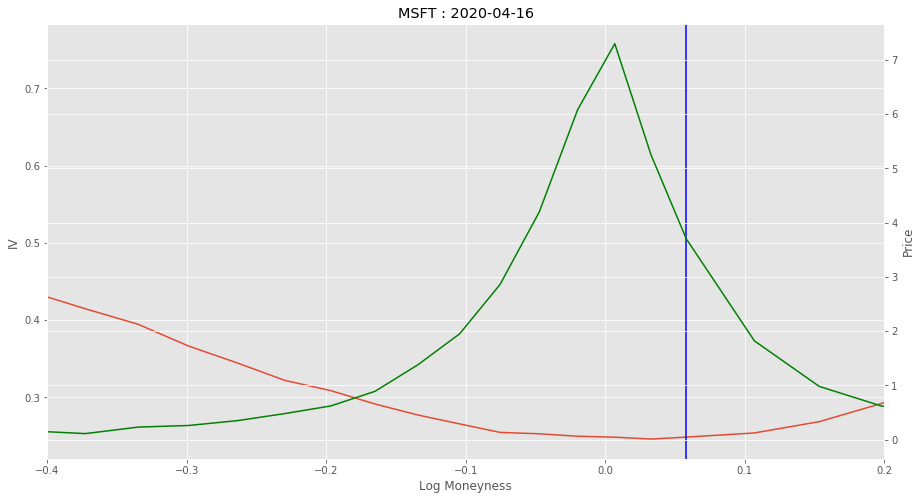

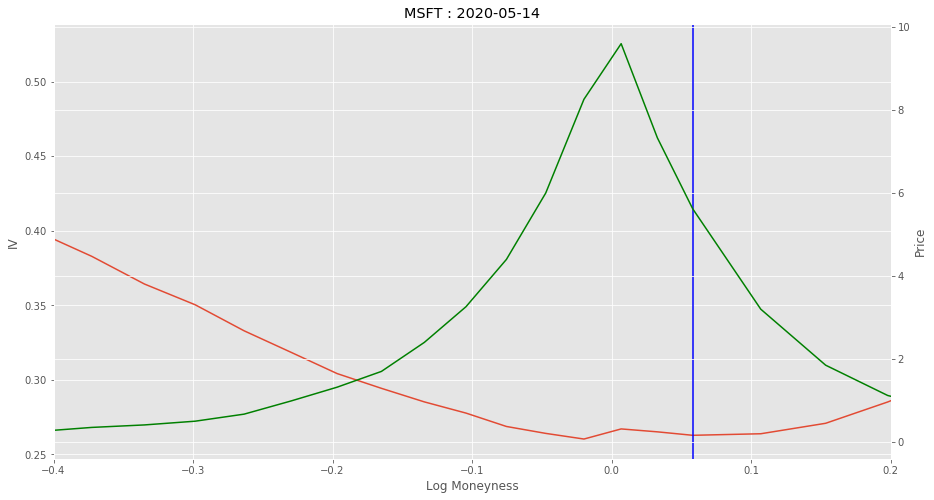

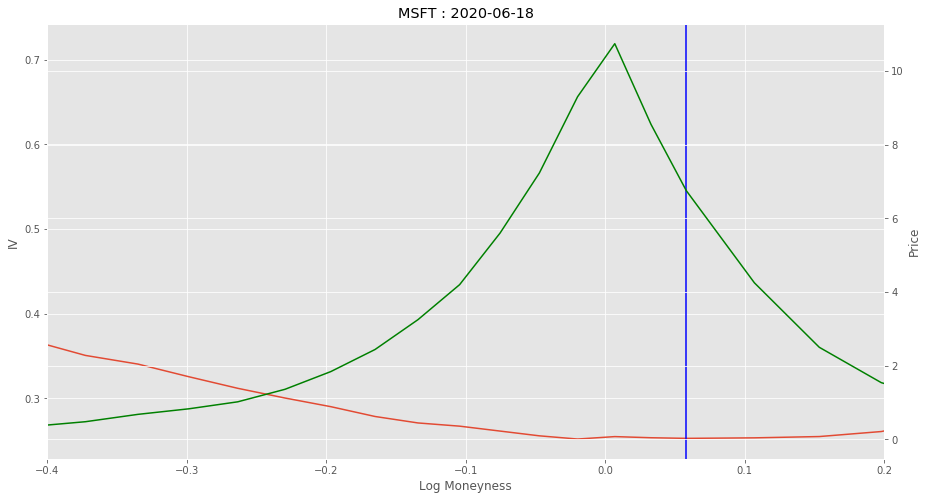

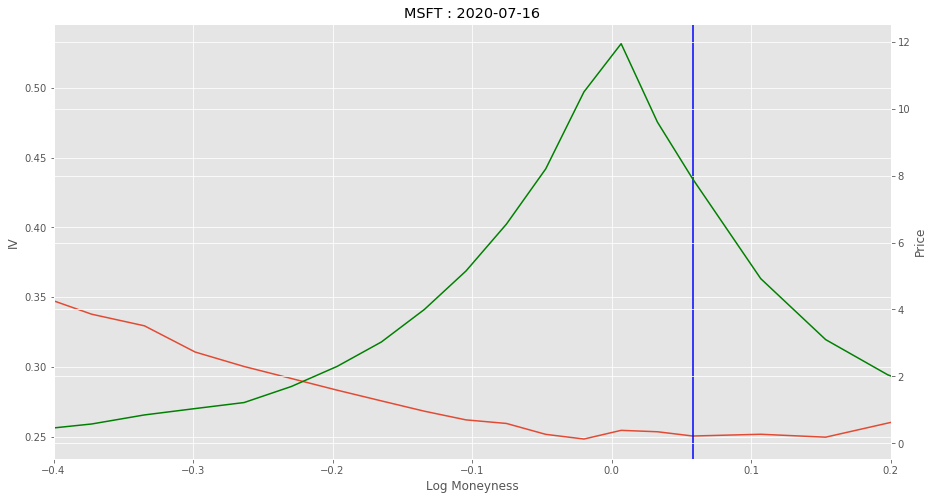

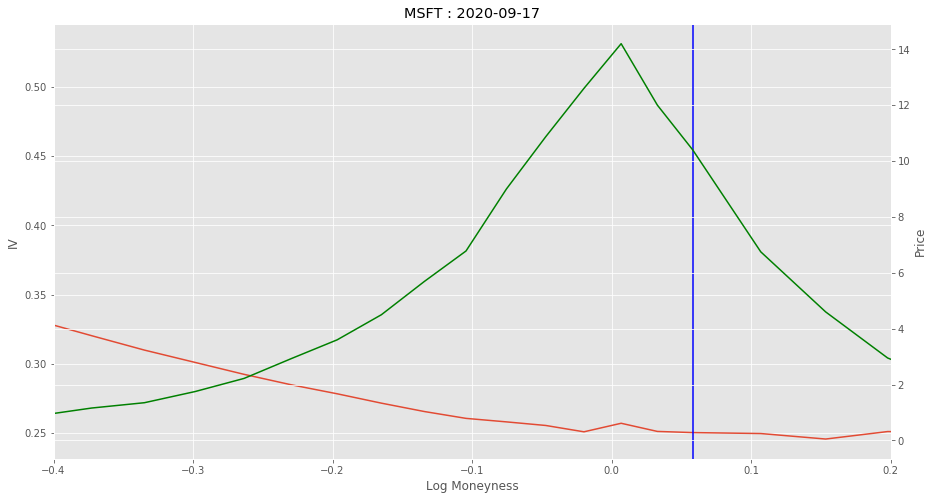

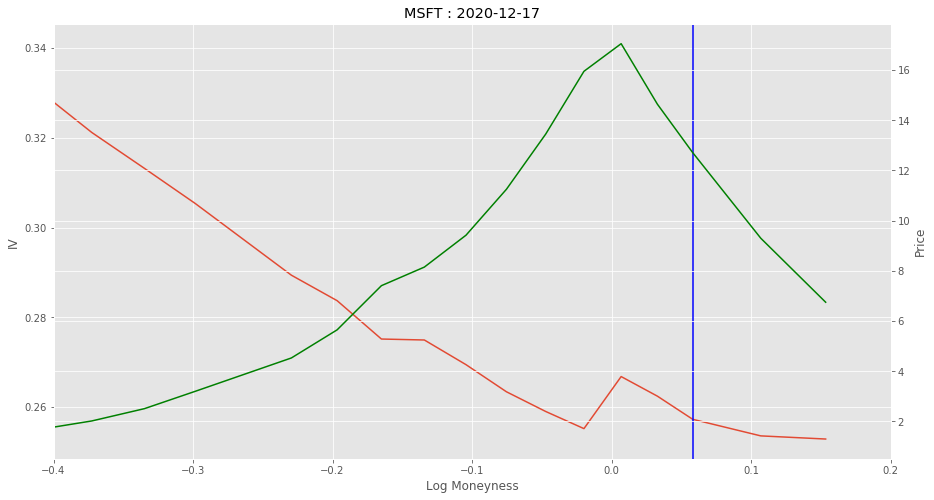

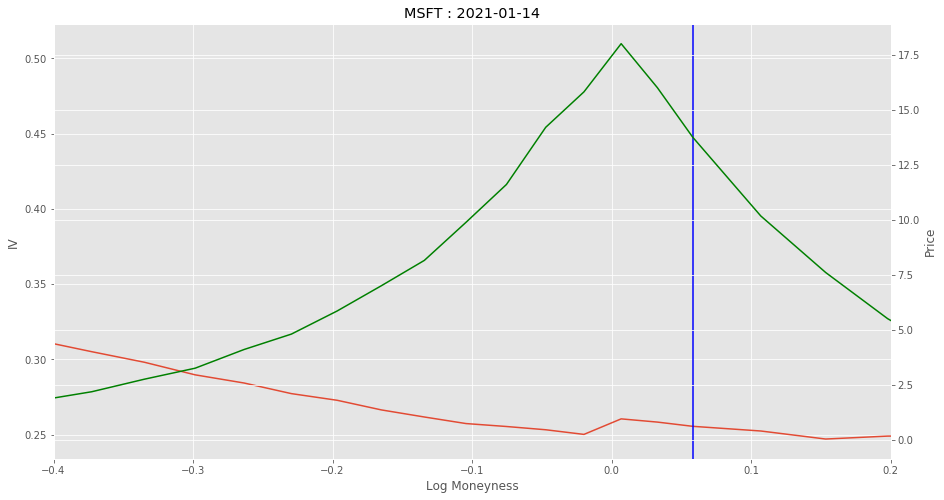

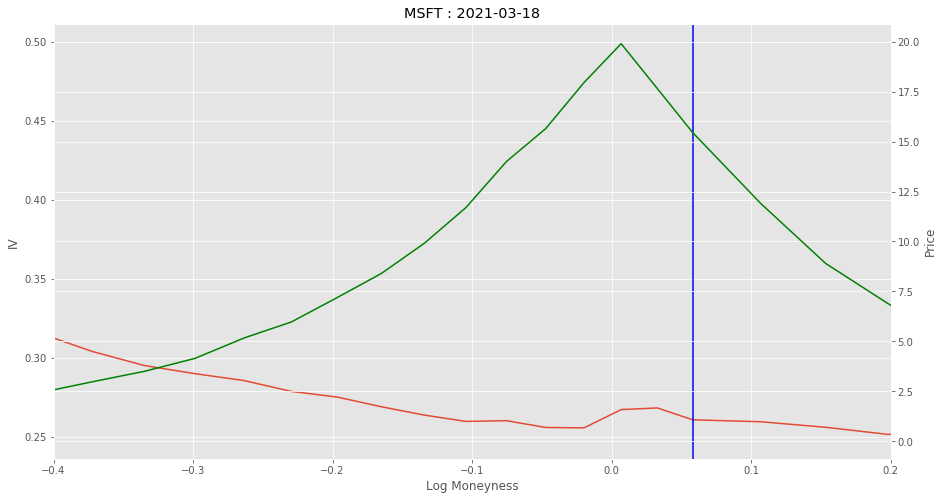

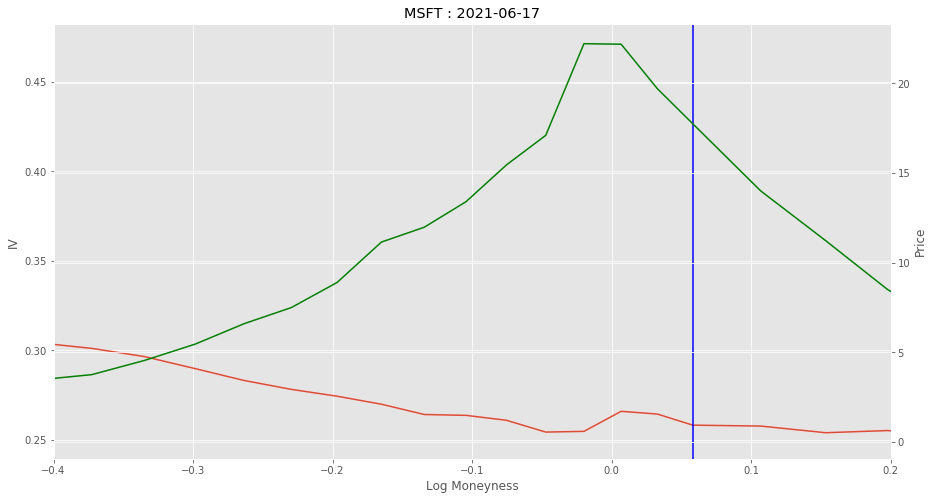

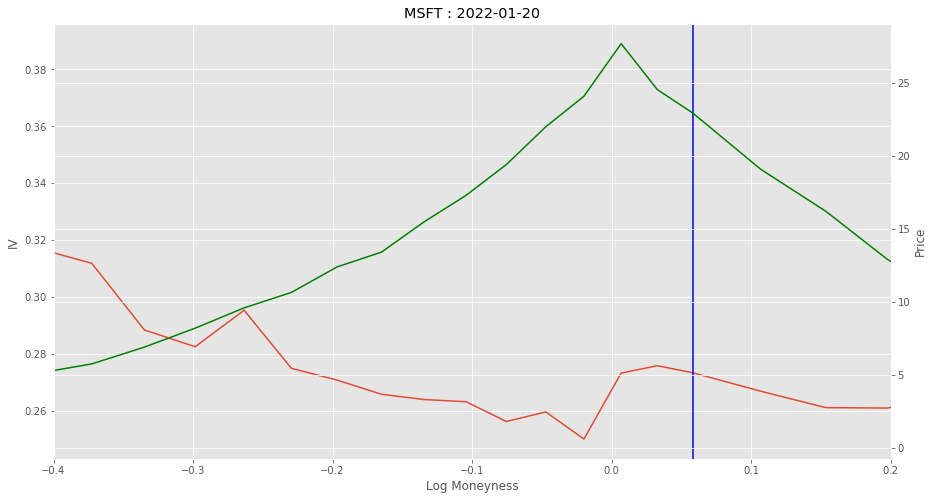

In [48]:
for symbol in symbols[:1]:
    symbol_data = otm_prices.loc[otm_prices.underlyingSymbol == symbol]
    expiries = symbol_data.expiry.unique()
    underlying_price = symbol_data.underlyingPrice.values[0]
    for expiry in expiries:
        plot_data = symbol_data.loc[symbol_data.expiry == expiry].sort_values("logMoneyness")
        fig, ax = plt.subplots(ncols=1, figsize=(15, 8))
        ax.plot(plot_data.logMoneyness, plot_data.impliedVolatility)
        plt.xlabel("Log Moneyness")
        plt.ylabel("IV")
        plt.title(f"{symbol} : {expiry}")
        plt.axvline(np.log(200.0 / underlying_price), color="blue")
        ax.set_xlim((-0.4, 0.2))
        
        ax2 = ax.twinx()
        ax2.plot(plot_data.logMoneyness, plot_data.lastPrice, color="green")
        ax2.set_ylabel("Price")
        plt.show()